In [1]:
import re
import pandas as pd
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [2]:
df = pd.read_csv("data.csv")
texts = df["full_text"].astype(str)
texts

0       @CakKhum Ya Smga ALLÀH dg Seluruh Kekuatan ALA...
1       @Nexus031191 @puzzwles jangan ada wamen2 yang ...
2       @sharpandshark mentri purbaya uang harus dipak...
3       @sharpandshark Beda dengan mentri purbaya sang...
4       new idol has been unlock Purbaya Yudhi Sadewaa...
                              ...                        
1513    Jurus 4: Perbaiki Sistem Coretax Sistem perpaj...
1514    Jurus 2: Kejar 200 Penunggak Pajak Kakap Pemer...
1515    Jurus 1: Stimulus Ekonomi 8+4+5 Purbaya yakin ...
1516    Penerimaan negara lagi turun tapi Menkeu Purba...
1517    5 Jurus Ampuh Menkeu Purbaya Dongkrak Penerima...
Name: full_text, Length: 1518, dtype: object

In [3]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_nltk = set(stopwords.words('indonesian'))
stop_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stop_words = stop_nltk.union(stop_sastrawi)

tokenizer = RegexpTokenizer(r'\w+')

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)    
    text = re.sub(r'@\w+', ' ', text)              
    text = emoji.demojize(text)                    
    text = re.sub(r'\d+',' ', text)                
    text = re.sub(r'[^\w\s]',' ', text)            
    text = re.sub(r'(.)\1{2,}', r'\1', text)       
    text = re.sub(r'\s+',' ', text).strip()

    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["clean_text"] = texts.apply(clean_text)


In [5]:
with open("inset_lexicon.json", "r", encoding="utf-8") as f:
    inset_lex = json.load(f)

pos_dict = inset_lex.get("positive", {})
neg_dict = inset_lex.get("negative", {})

def label_with_inset(text):
    score = 0.0
    for w in text.split():
        if w in pos_dict:
            score += pos_dict[w]
        elif w in neg_dict:
            score += neg_dict[w]
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["clean_text"].apply(label_with_inset)
print("Distribusi Sentimen (dengan InSet):\n", df["sentiment"].value_counts())


Distribusi Sentimen (dengan InSet):
 sentiment
positive    875
negative    479
neutral     164
Name: count, dtype: int64


In [6]:
X = df["clean_text"]
y = df["sentiment"]

vectorizer = TfidfVectorizer(max_features=1500)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [7]:
param_grid = {
    "C": [0.1, 1, 10],             
    "kernel": ["linear", "rbf"],   
    "gamma": ["scale", "auto"],     
    "class_weight": [None, "balanced"]
}

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring="f1_macro",  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (F1-macro):", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Classification Report (Best SVM):\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score (F1-macro): 0.5865852306007842
Classification Report (Best SVM):
               precision    recall  f1-score   support

    negative       0.68      0.52      0.59        97
     neutral       0.86      0.33      0.48        36
    positive       0.71      0.91      0.80       171

    accuracy                           0.71       304
   macro avg       0.75      0.59      0.62       304
weighted avg       0.72      0.71      0.69       304



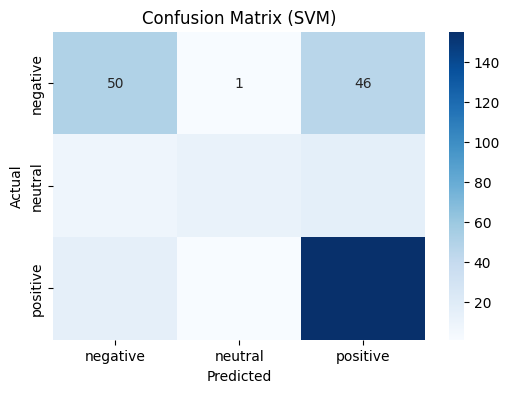

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=best_svm.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.show()


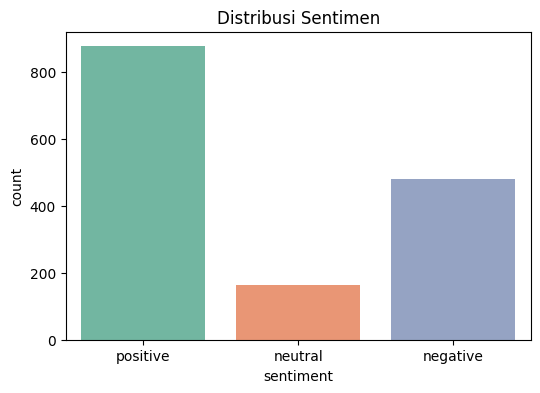

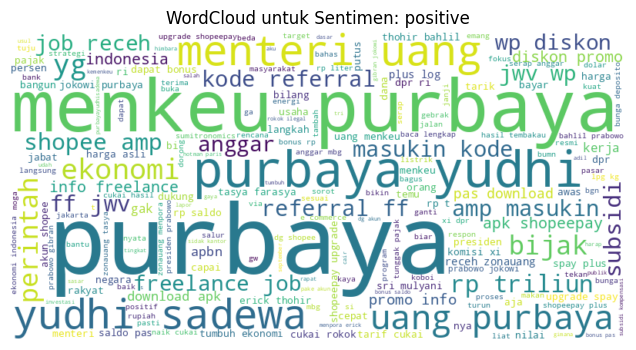

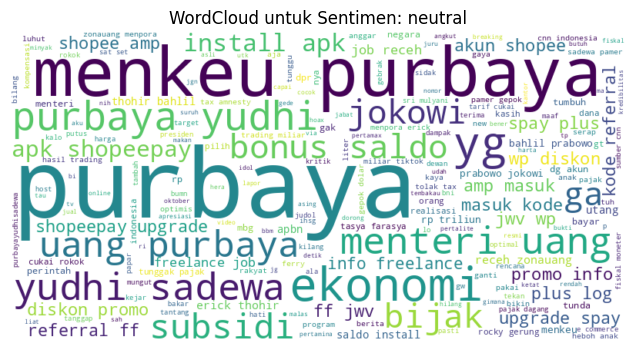

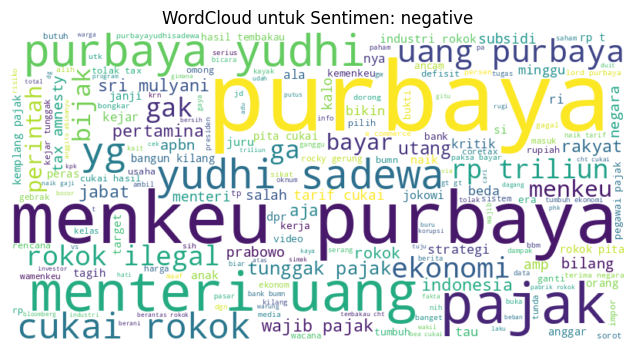

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df,
              order=["positive","neutral","negative"],
              palette="Set2")
plt.title("Distribusi Sentimen")
plt.show()

for sentiment in df["sentiment"].unique():
    text = " ".join(df[df["sentiment"]==sentiment]["clean_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Sentimen: {sentiment}")
    plt.show()
